This notebook aims to develop a unified preprocessing pipeline for both annual and seasonal models. It begins with a basic preprocessing framework and progressively extends it by testing different scalers and data aggregation strategies to identify the most effective configuration.

In [ ]:
from preprocessing_functions import *
from models_functions import *
from experiments_functions import *

import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Validate baseline preprocessing

In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
df = dict_to_dataframe(indicators_dict)

In [ ]:
# Statistical tests
normality_rx90p = pg.normality(df['rx90p_anom'], method='jarque_bera')
normality_pr = pg.normality(df['pr_anom'], method='jarque_bera')

print("Anderson-Darling test result for rx90p:\n", normality_rx90p)
print("\nAnderson-Darling test result for pr:\n", normality_pr)

In [ ]:
n_bootstrap = 1000
sample_size = len(df)

for indicator in ["rx90p_anom", "pr_anom"]:
    print(indicator)

    # Bootstrap sampling and variance calculation
    bootstrap_variances = [
        np.var(
            df[indicator].sample(n=sample_size, replace=True, random_state=123 + i),  # Vary seed per iteration
            ddof=1
        )
        for i in range(n_bootstrap)
    ]

    # Mean variance
    mean_variance = np.mean(bootstrap_variances)

    # Variance of the variance
    variance_of_variance = np.var(bootstrap_variances, ddof=1)

    # 95% confidence interval
    lower_ci, upper_ci = np.percentile(bootstrap_variances, [2.5, 97.5])

    print(f"Mean variance: {mean_variance:.4f}")
    print(f"Bootstrap estimate of variance of the variance: {variance_of_variance:.4f}")
    print(f"95% Confidence Interval for variance: [{lower_ci:.4f}, {upper_ci:.4f}]")

rx90p_anom
Mean variance: 35.8268
Bootstrap estimate of variance of the variance: 0.0194
95% Confidence Interval for variance: [35.5470, 36.1058]
pr_anom
Mean variance: 7.4710
Bootstrap estimate of variance of the variance: 0.0007
95% Confidence Interval for variance: [7.4194, 7.5242]


In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx1day", "pr", "rx90p"])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
bins = 30

for col_idx, (name, dataarray) in enumerate(indicators_dict.items()):
    # Original data histogram (first row)
    ax1 = axes[0, col_idx]
    data = dataarray.values.flatten()
    ax1.hist(data[~xr.ufuncs.isnan(data)], bins=bins)
    ax1.set_title(f'{name} (original)')

    # Annual resampled histogram (second row)
    ax2 = axes[1, col_idx]
    # Resample and take mean or another aggregation
    if 'time' in dataarray.dims:
        annual = dataarray.resample(time='YE').mean()
        data_annual = annual.values.flatten()
        ax2.hist(data_annual[~xr.ufuncs.isnan(data_annual)], bins=bins)
        ax2.set_title(f'{name} (annual resampled)')
    else:
        ax2.set_visible(False)

plt.tight_layout()
plt.show()

# Assume indicator_dict = {'indicator1': da1, 'indicator2': da2, 'indicator3': da3}
bins = 30

# First plot: Monthly/original data (all in one)
plt.figure(figsize=(10, 6))
for name, da in indicators_dict.items():
    data = da.values.flatten()
    data = data[~np.isnan(data)]
    plt.hist(data, bins=bins, alpha=0.5, label=name)
plt.title("Original Monthly Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Second plot: Annual resampled data (all in one)
plt.figure(figsize=(10, 6))
for name, da in indicators_dict.items():
    if 'time' in da.dims:
        annual = da.resample(time='YE').mean()
        data = annual.values.flatten()
        data = data[~np.isnan(data)]
        plt.hist(data, bins=bins, alpha=0.5, label=name)
plt.title("Annual Resampled Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
for name, da in indicators_dict.items():
    data = da.values.flatten()
    data = data[~np.isnan(data)]
    
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr

    severe_outliers = np.sum((data < lower_bound) | (data > upper_bound))
    total_values = len(data)
    percentage = (severe_outliers / total_values) * 100

    print(f"{name}: {percentage:.2f}% severe outliers ({severe_outliers} of {total_values})")



# Monthly boxplot (original data)
monthly_data = []
labels = []
for name, da in indicators_dict.items():
    data = da.values.flatten()
    data = data[~np.isnan(data)]
    monthly_data.append(data)
    labels.append(name)

plt.figure(figsize=(8, 6))
plt.boxplot(monthly_data, labels=labels)
plt.title("Boxplot of Monthly aggregation")
plt.ylabel("mm/day")
plt.grid(True)
plt.tight_layout()
plt.show()

# Annual boxplot (resampled data)
annual_data = []
labels = []
for name, da in indicators_dict.items():
    if 'time' in da.dims:
        annual = da.resample(time='YE').mean()
        data = annual.values.flatten()
        data = data[~np.isnan(data)]
        annual_data.append(data)
        labels.append(name)

plt.figure(figsize=(8, 6))
plt.boxplot(annual_data, labels=labels)
plt.title("Boxplot of Annual Resampled Data")
plt.ylabel("mm/day")
plt.grid(True)
plt.tight_layout()
plt.show()

# 1) Data transformation experiments

## test different scalars

In [48]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer

In [52]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
lagged_indicators_dict = indicators_calculate_extra_features(indicators_dict, lags = 1)

df = dict_to_dataframe(lagged_indicators_dict)
df_merged = df_add_index_variables(df, lags=6, trend = True, mean = True)

# One-hot encoding
categorical_columns = df_merged.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df_merged, columns=categorical_columns)

X_train, y_train, X_val, y_val = train_test_split(df_encoded, include_years=False)

models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                            "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                            experiment_name="NoScaling"
                                                            )
evaluate_models(X_val, y_val, models, experiment_name="NoScaling", store_testing=True, out_path="/home/vgarcia/experiments/Scalers/")

calculating montly mean for pr
---Training (MSE, MSSS, MAE, R2)---
LR: [32.80989956  6.6860998 ], [0.1124953  0.14466837], [3.41951763 1.67390214], [0.09716335 0.13633767]
RF: [2.22938584 0.31216869], [0.93969532 0.96006525], [0.77382857 0.28159533], [0.93865354 0.95967629]
All models trained
---Testing (MSE, MSSS, MAE, R2)---
Climatology: [35.67245781  6.96862713], [0. 0.], [3.71530516 1.73948519], [-0.05872119 -0.0459657 ]
NoScaling_LR: [32.64622803  6.20416731], [0.08483379 0.1097002 ], [3.58355352 1.65794875], [0.03109414 0.06877695]
NoScaling_RF: [34.16337492  6.58930818], [0.04230387 0.05443238], [3.67106787 1.71691608], [-0.01393319  0.0109687 ]


In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
lagged_indicators_dict = indicators_calculate_extra_features(indicators_dict, lags = 1)

df = dict_to_dataframe(lagged_indicators_dict)
df_merged = df_add_index_variables(df, lags=6, trend = True, mean = True)

# One-hot encoding
categorical_columns = df_merged.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df_merged, columns=categorical_columns)

scaler_name = ["MinMax", "MaxAbs", "Standard", "Robust", "Normalizer", "QuantileTransformer", "PercentileScaler"]

for i, scaler in enumerate([MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PercentileScaler]):
    print("Processing", scaler_name[i])
    df_scaled = scaler().fit_transform(df_encoded)

    if scaler != PercentileScaler:
        df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

    X_train, y_train, X_val, y_val = train_test_split(df_scaled, include_years=False)

    models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                                "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                                experiment_name=scaler_name[i]
                                                                )
    evaluate_models(X_val, y_val, models, experiment_name=scaler_name[i], store_testing=True, out_path="/home/vgarcia/experiments/Scalers/")

## Undo QuantileTransformer() transformation

here, we can see that QuantileTransformer does not preserve linearity

In [ ]:
quantile_transformer = QuantileTransformer()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df_merged, columns=categorical_columns)

df_scaled = quantile_transformer.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

df_undone = quantile_transformer.inverse_transform(df_scaled)

# Convert the undoes data back into a DataFrame
df_undone = pd.DataFrame(df_undone, columns=df_encoded.columns)
not_equal = df_undone["rx90p_anom"].round(6) != df_encoded["rx90p_anom"].round(6)

# Count how many rows are not equal
num_not_equal = not_equal.sum()

print(f"Number of rows that are not equal: {num_not_equal} ({100 * num_not_equal / len(df_undone)})")
print(rows_with_diff = df_undone["rx90p_anom"][not_equal])
print(df_encoded["rx90p_anom"][not_equal])
#corr_plot(df_encoded, title=f"Correlation before Quantile transformation", outpath="/home/vgarcia/corr_before_scaling.png")
#corr_plot(df_scaled, title=f"Correlation after Quantile transformation", outpath="/home/vgarcia/corr_after_scaling.png")

## Undo custom Percentile Scaling

In contrast, custom percentile scalar achieves to easily undo transformations

In [ ]:
quantile_transformer = PercentileScaler()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df_merged, columns=categorical_columns)

df_scaled = quantile_transformer.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

df_undone = quantile_transformer.inverse_transform(df_scaled)

# Convert the undoes data back into a DataFrame
df_undone = pd.DataFrame(df_undone, columns=df_encoded.columns)
not_equal = df_undone["rx90p_anom"].round(6) != df_encoded["rx90p_anom"].round(6)

# Count how many rows are not equal
num_not_equal = not_equal.sum()


In [ ]:
print(f"Number of rows that are not equal: {num_not_equal}")
rows_with_diff = df_undone["rx90p_anom"][not_equal]
rows_with_diff
df_encoded["rx90p_anom"][not_equal]

# 2) Coordinate aggregation strategies

## No aggregation

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Baseline to compare how good is the aggregation
indicators_dict = calculate_indicators(indicators=["rx90p", "pr"])

pr_baseline = indicators_dict["pr_anom"].quantile(0.50, dim = "time").drop_vars("quantile")
rx90p_baseline = indicators_dict["rx90p_anom"].quantile(0.50, dim = "time").drop_vars("quantile")

ds = xr.Dataset({"pr_anom" : pr_baseline,
                 "rx90p_anom" : rx90p_baseline})

calculating montly mean for pr


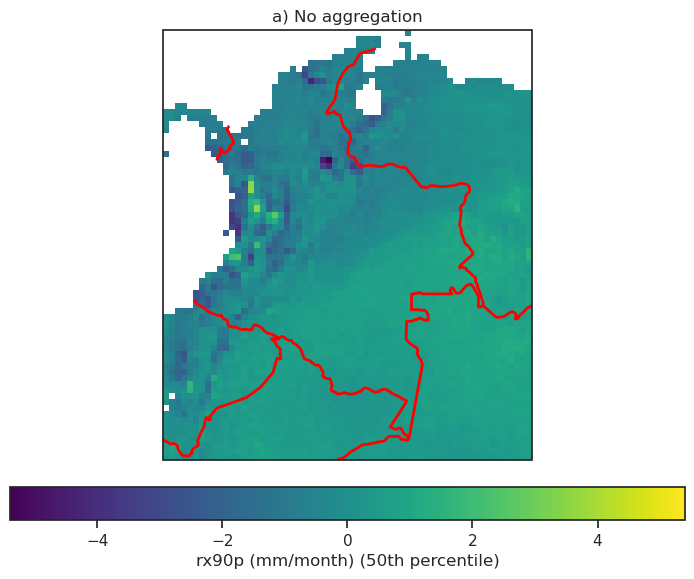

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data without auto-creating the colorbar
plot = ds["rx90p_anom"].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    add_colorbar=False  # Disable auto colorbar to customize layout
)

# Add a manually positioned horizontal colorbar below the map
cbar = fig.colorbar(
    plot, 
    ax=ax, 
    orientation='horizontal', 
    pad=0.05,  # Small space between map and colorbar
    shrink=0.7,  # Adjust shrink if needed to fit well
    label="rx90p (mm/month) (50th percentile)"
)

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=2)

# Set title
plt.title("a) No aggregation")

# Show the plot
plt.tight_layout()  # Ensures no clipping
plt.savefig("baseline_rx90p_anom50p.png", bbox_inches="tight", dpi=300)
plt.show()

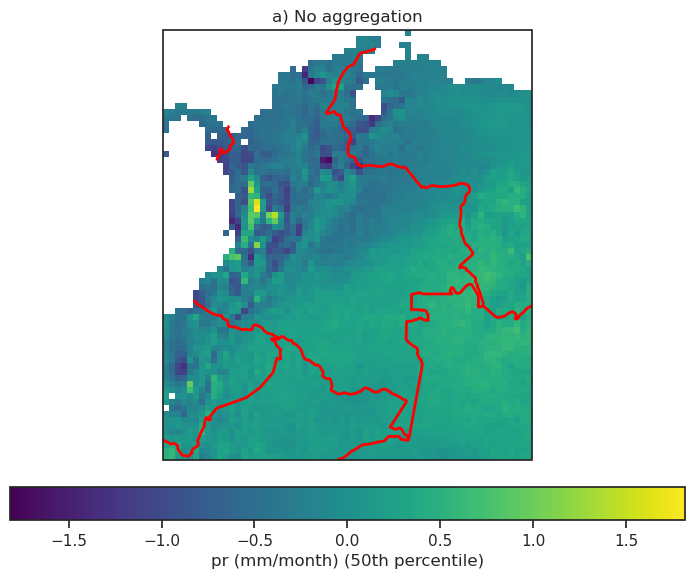

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data without auto-creating the colorbar
plot = ds["pr_anom"].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    add_colorbar=False  # Disable auto colorbar to customize layout
)

# Add a manually positioned horizontal colorbar below the map
cbar = fig.colorbar(
    plot, 
    ax=ax, 
    orientation='horizontal', 
    pad=0.05,  # Small space between map and colorbar
    shrink=0.7,  # Adjust shrink if needed to fit well
    label="pr (mm/month) (50th percentile)"
)

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=2)

# Set title
plt.title("a) No aggregation")

# Show the plot
plt.tight_layout()  # Ensures no clipping
plt.savefig("baseline_pr_anom_50p.png", bbox_inches="tight", dpi=300)
plt.show()

## Group coords by countries

In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
indicators_dict = indicators_calculate_extra_features(indicators_dict)
df = dict_to_dataframe(indicators_dict)

# Aggregate by coords
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert to GeoDataFrame, and set the same CRS as the shapefile (usually WGS84: EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Perform spatial join to add department info (e.g., 'name', 'admin', etc.
provinces = gpd.read_file('/data/dl20-data/climate_operational/Victor_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

joined = gpd.sjoin(gdf, provinces[['geometry', 'name']], how='left', predicate='within')

joined = joined.drop(["geometry", "index_right"], axis=1)
df = joined.groupby(["time", "name"]).median().reset_index()

#df.to_csv("median_coords_by_department.csv")

In [29]:
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert to GeoDataFrame, and set the same CRS as the shapefile (usually WGS84: EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Perform spatial join to add department info (e.g., 'name', 'admin', etc.
provinces = gpd.read_file('/data/dl20-data/climate_operational/Victor_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

joined = gpd.sjoin(gdf, provinces[['geometry', 'name']], how='left', predicate='within')

joined = joined.drop(["geometry", "index_right"], axis=1)
df = joined.groupby(["time", "name"]).median().reset_index()

#df.to_csv("median_coords_by_department.csv")

### Process pr_anom

In [30]:
# Add shapefiles
gdf = provinces[["name", "geometry"]]

gdf_merged = gdf.merge(df, how="right", on="name")

gdf_50th = (
    gdf_merged
    .groupby(['name', 'geometry'], as_index=False)['pr_anom']
    .quantile(0.50)
)

# Step 2: Convert to GeoDataFrame
gdf_50th = gpd.GeoDataFrame(gdf_50th, geometry='geometry')

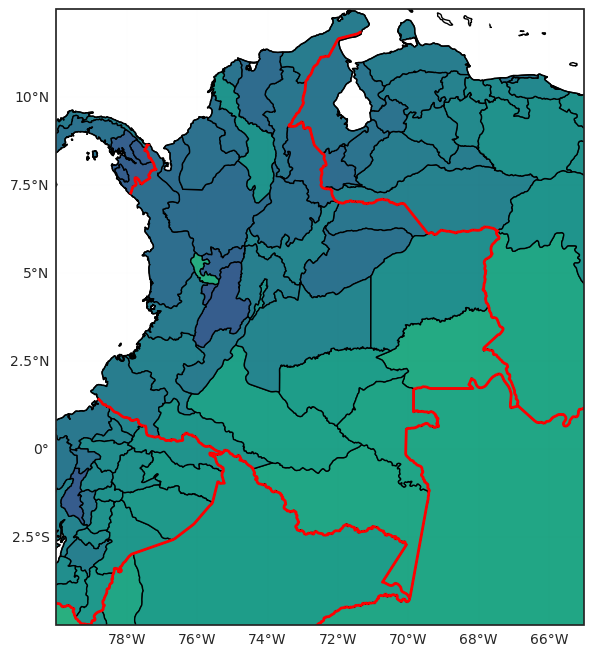

In [ ]:
# Create a Cartopy projection
proj = ccrs.PlateCarree()

# Set up figure and GeoAxes with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

# Plot using GeoPandas on the Cartopy GeoAxes
gdf_50th.plot(
    column='pr_anom',
    cmap='viridis',
    legend=False,
    ax=ax,
    edgecolor='black',
    vmin=ds.pr_anom.min().values,
    vmax=ds.pr_anom.max().values,
    transform=ccrs.PlateCarree()  
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.01, color='gray', alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-80, -65, -5, 12.5], crs=ccrs.PlateCarree())

# Optional: add coastlines or borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=2)

# Save figure
plt.savefig("pr_anom_departments_50p.png", dpi=300, bbox_inches='tight')
plt.show()

### Process rx90p

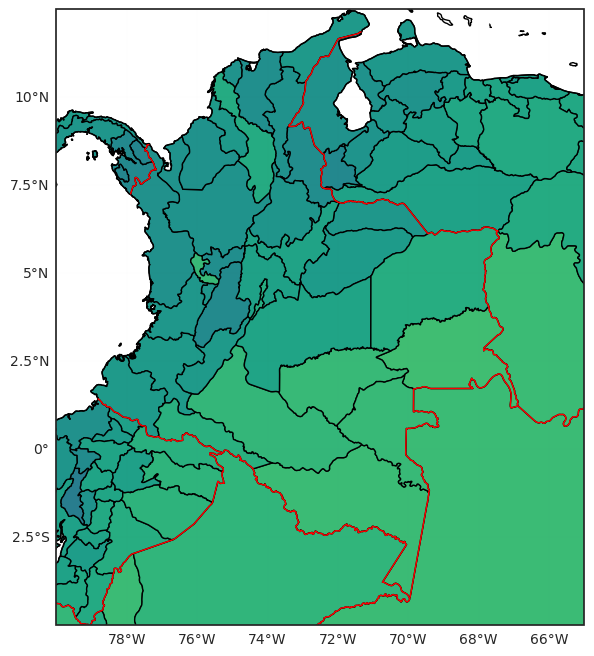

In [34]:
# Add shapefiles
gdf = provinces[["name", "geometry"]]

gdf_merged = gdf.merge(df, how="right", on="name")

gdf_50th = (
    gdf_merged
    .groupby(['name', 'geometry'], as_index=False)['rx90p_anom']
    .quantile(0.50)
)

# Step 2: Convert to GeoDataFrame
gdf_50th = gpd.GeoDataFrame(gdf_50th, geometry='geometry')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Cartopy projection
proj = ccrs.PlateCarree()

# Set up figure and GeoAxes with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

# Plot using GeoPandas on the Cartopy GeoAxes
gdf_50th.plot(
    column='rx90p_anom',
    cmap='viridis',
    legend=False,
    ax=ax,
    edgecolor='black',
    vmin=ds.rx90p_anom.min().values,
    vmax=ds.rx90p_anom.max().values,
    transform=ccrs.PlateCarree()  # Tell Cartopy this data is in lat/lon
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.01, color='gray', alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-80, -65, -5, 12.5], crs=ccrs.PlateCarree())

# Optional: add coastlines or borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=1)

# Save figure
plt.savefig("rx90p_departments_50p.png", dpi=300, bbox_inches='tight')
plt.show()

### combine figures

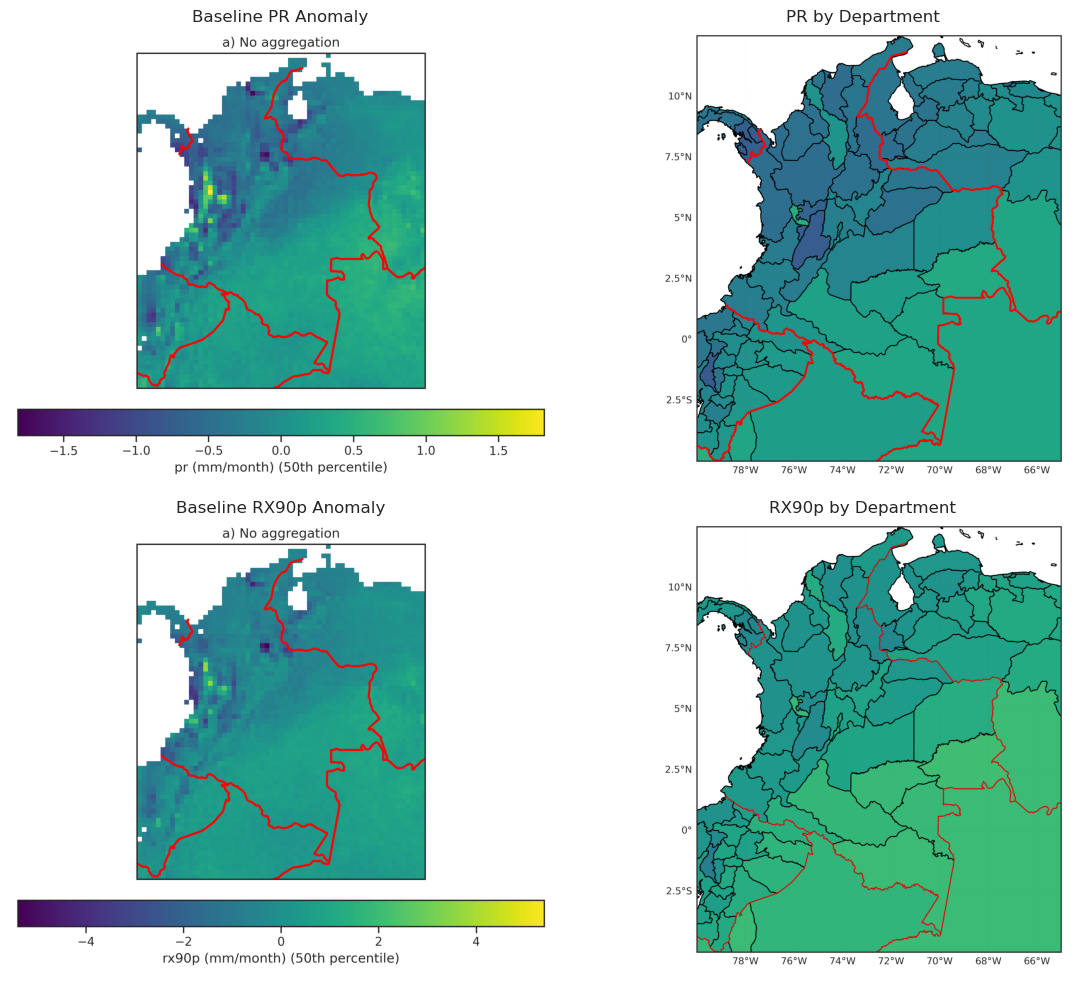

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img1 = mpimg.imread('/home/vgarcia/notebooks/baseline_pr_anom_50p.png')
img2 = mpimg.imread('/home/vgarcia/notebooks/baseline_rx90p_anom_50p.png')
img3 = mpimg.imread('/home/vgarcia/notebooks/pr_anom_departments_50p.png')
img4 = mpimg.imread('/home/vgarcia/notebooks/rx90p_departments_50p.png')

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First column
axs[0, 0].imshow(img1)
axs[1, 0].imshow(img2)

# Second column
axs[0, 1].imshow(img3)
axs[1, 1].imshow(img4)

# Turn off axes
for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

# Optional: Add subplot titles
axs[0, 0].set_title("Baseline PR Anomaly")
axs[1, 0].set_title("Baseline RX90p Anomaly")
axs[0, 1].set_title("PR by Department")
axs[1, 1].set_title("RX90p by Department")

# Save and show
plt.tight_layout()
plt.subplots_adjust(wspace=0)  # fine-tune further if needed
plt.savefig("combined_figure.png", dpi=300)
plt.show()

### Test models

In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
indicators_dict = indicators_calculate_extra_features(indicators_dict)
df = dict_to_dataframe(lagged_indicators_dict)
df_merged = df_add_index_variables(df, lags=6, trend = True, mean = True)

# Aggregate by coords
df_merged['geometry'] = df_merged.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert to GeoDataFrame, and set the same CRS as the shapefile (usually WGS84: EPSG:4326)
gdf = gpd.GeoDataFrame(df_merged, geometry='geometry', crs='EPSG:4326')

# Perform spatial join to add department info (e.g., 'name', 'admin', etc.
provinces = gpd.read_file('/data/dl20-data/climate_operational/Victor_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

joined = gpd.sjoin(gdf, provinces[['geometry', 'name']], how='left', predicate='within')

joined = joined.drop(["geometry", "index_right"], axis=1)
df = joined.groupby(["time", "name"]).median().reset_index()
df["month"] = df["time"].dt.month

# df.to_csv("median_coords_by_department.csv")
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)

calculating montly mean for pr


In [15]:
# Transforms
numeric_columns = df_encoded.select_dtypes(include=['float64', "float32", 'int64', "int32"]).columns

# Apply QuantileTransformer only to numeric columns
quantile_transformer = QuantileTransformer()
df_scaled_numeric = quantile_transformer.fit_transform(df_encoded[numeric_columns])

# Create a DataFrame from the scaled numeric values
df_scaled_numeric = pd.DataFrame(df_scaled_numeric, columns=numeric_columns)

# Replace the numeric columns in the original encoded DataFrame with the scaled ones
df_encoded[numeric_columns] = df_scaled_numeric

df_encoded["year"] = df_encoded["time"].dt.year

In [ ]:
# test models
X_train, y_train, X_val, y_val = train_test_split(df_encoded, include_years=False)

models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                            "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                            experiment_name="Dep"
                                                            )
evaluate_models(X_val, y_val, models, experiment_name = "Dep", store_testing=True, out_path="/home/vgarcia/experiments/CoordsAggr/")

---Training (MSE, MSSS, MAE, R2)---
LinearRegression()
LR: [0.07631274 0.0755384 ], [0.10711649 0.12724588], [0.23427184 0.23258427], [0.09891462 0.12073558]
All models trained
RandomForestRegressor(random_state=123)
RF: [0.01105513 0.01089342], [0.87065146 0.87413977], [0.08601131 0.08499737], [0.86946328 0.87320092]
All models trained
---Testing (MSE, MSSS, MAE, R2)---
Climatology: [0.08491396 0.08389606], [0. 0.], [0.24867131 0.24730271], [-0.01965138 -0.02675802]
Dep_LR: [0.07754626 0.07533431], [0.08676669 0.10205183], [0.23636274 0.23185454], [0.0688204  0.07802452]
Dep_RF: [0.08167688 0.07931011], [0.03812193 0.05466223], [0.2356433  0.23113882], [0.0192197  0.02936687]


## Group coords by clusters

### without time dimension

In [ ]:
df = ds.to_dataframe()
df_no_nan = df.dropna().reset_index()

<Axes: >

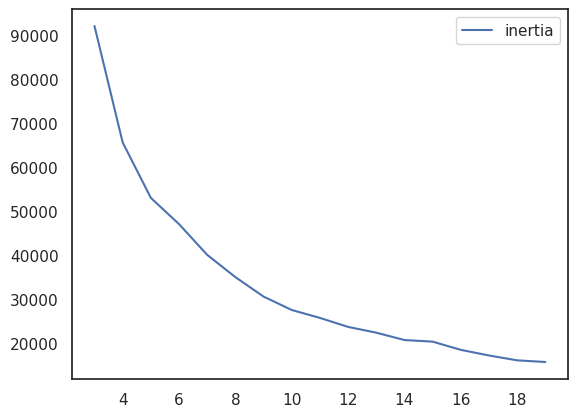

In [69]:
elbow = {k: KMeans(k).fit(df_no_nan).inertia_ for k in range(3,20)}

elbow_df = pd.DataFrame(elbow, index=['inertia']).T

elbow_df.plot(grid=False)

In [70]:
tkm = KMeans(9)
df_no_nan['geog_centroid_id'] = tkm.fit_predict(df_no_nan)

In [71]:
from shapely.geometry import MultiPoint
geometry = [Point(xy) for xy in zip(df_no_nan['lon'], df_no_nan['lat'])]

# Convert to GeoDataFrame with WGS84 CRS
gdf = gpd.GeoDataFrame(df_no_nan, geometry=geometry, crs='EPSG:4326')

gdf_grouped = gdf.groupby('geog_centroid_id').agg({
        'rx90p_anom': 'mean',       # Replace or extend with your column names
        "pr_anom" : "mean",
        'geometry': lambda x: MultiPoint(x.tolist())
    })

# Create a new GeoDataFrame
gdf_grouped = gpd.GeoDataFrame(gdf_grouped, geometry='geometry', crs=gdf.crs)

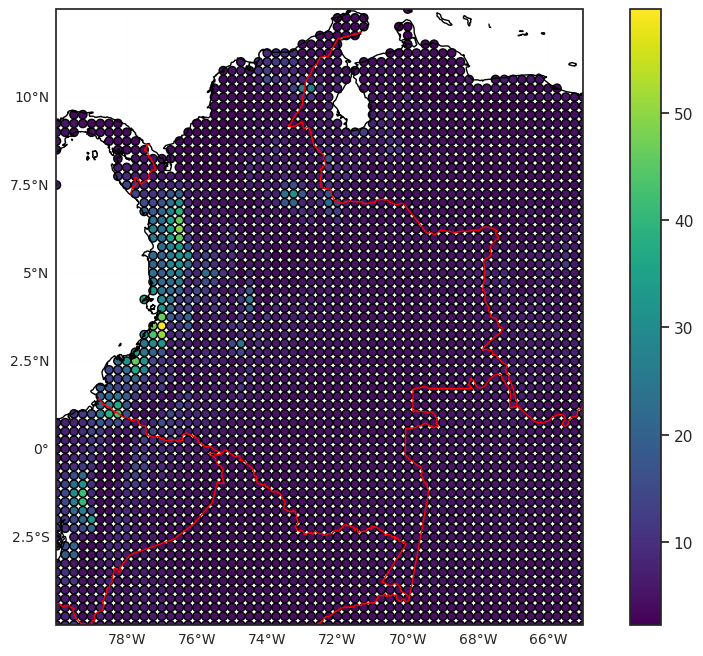

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Cartopy projection
proj = ccrs.PlateCarree()

# Set up figure and GeoAxes with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

# Plot using GeoPandas on the Cartopy GeoAxes
gdf.plot(
    column='rx90p_anom',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    transform=ccrs.PlateCarree()  # Tell Cartopy this data is in lat/lon
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.01, color='gray', alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-80, -65, -5, 12.5], crs=ccrs.PlateCarree())

# Optional: add coastlines or borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=1)

# Save figure
plt.savefig("rx90p_anom_departments.png", dpi=300, bbox_inches='tight')
plt.show()

### with time dimension

In [ ]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
indicators_dict = indicators_calculate_extra_features(indicators_dict)

df = dict_to_dataframe(indicators_dict)
df_scaled = encode_and_scale(df)
df_no_nan = df_scaled.dropna()
df_no_nan.drop("time", axis = 1)
df_no_nan = df_no_nan.drop("time", axis = 1)

calculating montly mean for pr


<Axes: >

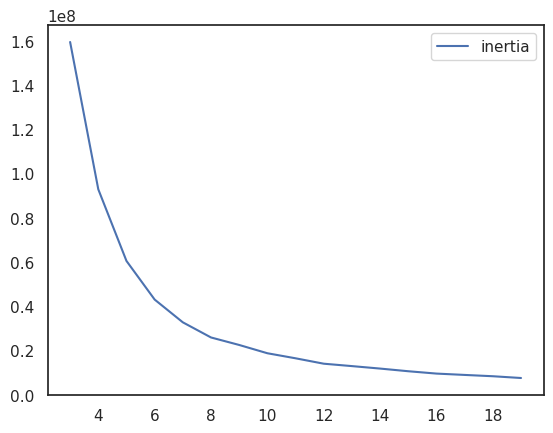

In [34]:
# fast method for deciding number of clusters
elbow = {k: KMeans(k).fit(df_no_nan).inertia_ for k in range(3,20)}

elbow_df = pd.DataFrame(elbow, index=['inertia']).T

elbow_df.plot(grid=False)

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

silhouette_scores = {}
ch_scores = {}
db_scores = {}

# Loop once and reuse labels
for k in range(3, 20):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(df_no_nan)
    
    silhouette_scores[k] = silhouette_score(df_no_nan, labels)
    ch_scores[k] = calinski_harabasz_score(df_no_nan, labels)
    db_scores[k] = davies_bouldin_score(df_no_nan, labels)

# Convert to DataFrames
silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['silhouette'])
ch_df = pd.DataFrame.from_dict(ch_scores, orient='index', columns=['calinski_harabasz'])
db_df = pd.DataFrame.from_dict(db_scores, orient='index', columns=['davies_bouldin'])

# Combine if needed
metrics_df = pd.concat([silhouette_df, ch_df, db_df], axis=1)
metrics_df.plot(subplots=True, layout=(2,2), figsize=(10,8), title='Clustering Metrics')

KeyboardInterrupt: 

In [ ]:
# use clusters
kmeans = KMeans(n_clusters=9, random_state=42)
df_no_nan["cluster_id"] = kmeans.fit_predict(df_no_nan)


In [39]:
X_train, y_train, X_val, y_val = train_test_split(df_no_nan, include_years=False)

models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                            "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                            experiment_name="Cluster"
                                                            )
evaluate_models(X_val, y_val, models, experiment_name = "Cluster", store_testing=True, out_path="/home/vgarcia/experiments/CoordsAggr/")

---Training (MSE, MSSS, MAE, R2)---
LinearRegression()
LR: [0.07693308 0.07494762], [0.08128909 0.1108741 ], [0.23640774 0.23184469], [0.06602613 0.10186987]
RandomForestRegressor(random_state=123)
RF: [0.00395991 0.00217035], [0.95271193 0.97425249], [0.04612137 0.03109423], [0.95192632 0.97399174]
All models trained
---Testing (MSE, MSSS, MAE, R2)---
Climatology: [0.08911111 0.08309411], [0. 0.], [0.25529055 0.24460231], [-0.04506248 -0.02470983]
Cluster_LR: [0.08210091 0.07534067], [0.07866805 0.09330914], [0.24555346 0.23216015], [0.03715055 0.07090496]
Cluster_RF: [0.08725882 0.08414525], [ 0.02078634 -0.01264997], [0.24592628 0.23792865], [-0.02333945 -0.03767238]


## Group coords by climate zones

In [26]:
from kgcpy import lookupCZ
from shapely import wkt

In [28]:
indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
indicators_dict = indicators_calculate_extra_features(indicators_dict)
df = dict_to_dataframe(indicators_dict)
df_merged = df_add_index_variables(df, lags=6, trend = True, mean = True)

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Convert to GeoDataFrame with WGS84 CRS
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

calculating montly mean for pr


/home/vgarcia/miniconda3/envs/myenv/lib/python3.11/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [29]:
# Calculate the zone for each point
unique_coords = gdf[['lat', 'lon']].drop_duplicates()

# Step 2: Apply the lookup function once per unique pair
unique_coords['zone'] = unique_coords.apply(lambda row: lookupCZ(row.lat, row.lon), axis=1)

# Step 3: Merge back into the original GeoDataFrame
gdf = gdf.merge(unique_coords, on=['lat', 'lon'], how='left')

In [50]:
df_scaled = encode_and_scale(gdf)
df_scaled = df_scaled.drop(["geometry", "time"], axis = 1)

### Plot

In [ ]:
from shapely.geometry import MultiPoint
gdf_grouped = gdf.groupby('zone').agg({
        'rx90p_anom': lambda x: x.quantile(0.90),       # Replace or extend with your column names
        "pr_anom" : "mean",
        'geometry': lambda x: MultiPoint(x.tolist())
    })

# Create a new GeoDataFrame
gdf_grouped = gpd.GeoDataFrame(gdf_grouped, geometry='geometry', crs=gdf.crs).reset_index()

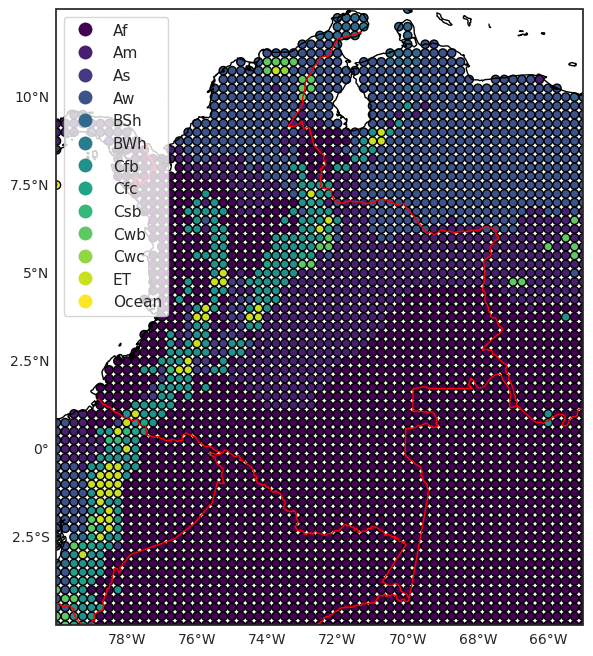

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Cartopy projection
proj = ccrs.PlateCarree()

# Set up figure and GeoAxes with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

# Plot using GeoPandas on the Cartopy GeoAxes
gdf_grouped.plot(
    column='zone',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    transform=ccrs.PlateCarree()  # Tell Cartopy this data is in lat/lon
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.01, color='gray', alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-80, -65, -5, 12.5], crs=ccrs.PlateCarree())

# Optional: add coastlines or borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='red', linewidth=1)

# Save figure
plt.savefig("Zones.png", dpi=300, bbox_inches='tight')
plt.show()

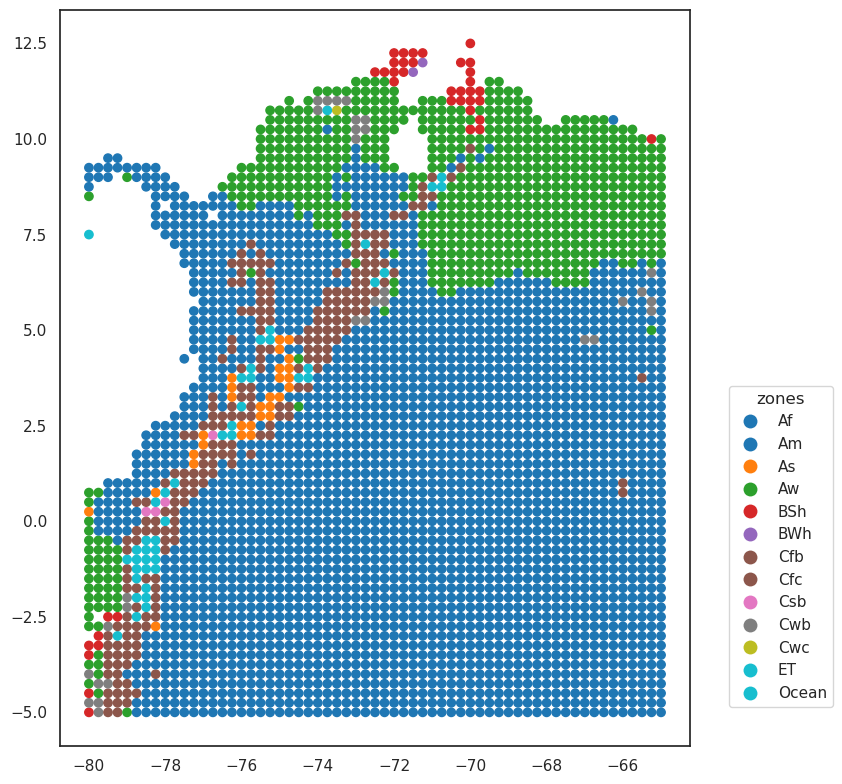

In [ ]:
#subset = gdf[(gdf["year"] == 2000) & (gdf["month"] == 1)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
gdf.plot(column="zone", legend=True, ax=ax)

# Adjust legend position (right side)
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((1.05, 0.5))  # (x, y) - x > 1 moves it to the right
    leg.set_title("zones")  # Optional: Set a custom legend title

plt.tight_layout()
plt.show()


### Model

In [52]:
# Train/test split
X_train, y_train, X_val, y_val = train_test_split(df_scaled)

models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                            "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                            experiment_name="ClimZones"
                                                            )
evaluate_models(X_val, y_val, models, experiment_name = "ClimZones", store_testing=True, out_path="/home/vgarcia/experiments/CoordsAggr/")


---Training (MSE, MSSS, MAE, R2)---
LR: [0.07589873 0.07562346], [0.09003893 0.11404941], [0.23450927 0.23353587], [0.0755276  0.10557834]
RF: [0.00407438 0.00236691], [0.95115163 0.97227096], [0.04695459 0.03253307], [0.95037263 0.97200583]
All models trained
---Testing (MSE, MSSS, MAE, R2)---
Climatology: [0.08852405 0.0840262 ], [0. 0.], [0.25475588 0.24752829], [-0.04526838 -0.02453445]
ClimZones_LR: [0.08126771 0.08276922], [0.08197024 0.01495937], [0.24353882 0.24356406], [ 0.04041251 -0.00920807]
ClimZones_RF: [0.10823842 0.11150489], [-0.22270075 -0.32702521], [0.26367782 0.26540998], [-0.27805044 -0.35958305]


## Group coords by groups

In [ ]:
n_aggregation = [3, 5, 7, 10]
aggregation_functions = [100]

# Store results
results = []

for n in n_aggregation:
    for aggregation_function in aggregation_functions:
        out_path = f"/home/vgarcia/experiments/{n}_aggr_{aggregation_function}.png"

        indicators_dict = calculate_indicators(indicators = ["rx90p", "pr"])
        lagged_indicators_dict = indicators_calculate_extra_features(indicators_dict, lags = 1)

        aggregated_indicators = aggregate_by_pixel(lagged_indicators_dict, n, aggregation_function)
        
        df = dict_to_dataframe(aggregated_indicators)
        print(len(df))

        df_merged = df_add_index_variables(df)

        # One-hot encoding
        df_scaled = encode_and_scale(df_merged)
        # Correlation heatmap
        #corr_plot(df_encoded, title=f"Aggregation={n}, funct={aggregation_function}", outpath=out_path)

        # Train/test split
        X_train, y_train, X_val, y_val = train_test_split(df_scaled)

        models = build_and_train_models(X_train, y_train, models = {"LR" : LinearRegression(),
                                                        "RF" : RandomForestRegressor(n_estimators=100, random_state=123)},
                                                        experiment_name = f"{n}_{aggregation_function}"
                                                        )
        
        evaluate_models(X_val, y_val, models, experiment_name = f"{n}_{aggregation_function}", store_testing=True, out_path="/home/vgarcia/experiments/Coords_aggr/")


# Plot experiments

## Coarsen experiment

In [11]:
df_sorted, baseline_df = load_experiment_results("/home/vgarcia/experiments/Coords_coarsen", models = ["RF", "LR"], baseline_name="baseline")


In [12]:
baseline_df = pd.DataFrame.from_dict(baseline_df, orient='index')
baseline_df.columns = [col + '_Diff' if col != 'Model' else col for col in baseline_df.columns]
df_sorted = df_sorted[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]
baseline_df = baseline_df[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]
full_df = pd.concat([df_sorted, baseline_df], ignore_index=True)
full_df.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n & Model & MSE_rx90p_anom_Diff & MSE_pr_anom_Diff & R2_rx90p_anom_Diff & R2_pr_anom_Diff \\\\\n\\midrule\n0 & 7_100_RF & 40.820044 & 5.859822 & 0.312780 & 0.293989 \\\\\n1 & 5_100_RF & 11.449870 & 1.833899 & 0.178362 & 0.210953 \\\\\n2 & 3_100_RF & 12.431790 & 2.050763 & 0.162046 & 0.133930 \\\\\n3 & 10_100_RF & 23.204631 & 2.286267 & 0.139495 & 0.178302 \\\\\n4 & 7_100_LR & 62.031682 & 9.322008 & 0.083343 & 0.071223 \\\\\n5 & 7_mean_RF & -17.349691 & -3.036096 & 0.071483 & 0.094528 \\\\\n6 & 5_mean_RF & -14.621319 & -2.458673 & 0.066454 & 0.086345 \\\\\n7 & 3_75_RF & -11.439137 & -1.793598 & 0.061597 & 0.054954 \\\\\n8 & 3_mean_RF & -9.484729 & -1.566416 & 0.059264 & 0.069430 \\\\\n9 & 10_mean_RF & -10.202795 & -1.950548 & 0.049169 & 0.102059 \\\\\n10 & 7_50_RF & -24.961758 & -4.079486 & 0.047761 & 0.064048 \\\\\n11 & 3_50_RF & -17.229575 & -2.796102 & 0.039551 & 0.052911 \\\\\n12 & 7_75_RF & -22.270173 & -3.544501 & 0.039330 & 0.050507 \\\\\n13 &

In [ ]:
df_sorted, baseline_df = load_experiment_results("/home/vgarcia/experiments/Coords_coarsen", models = ["RF", "LR"], baseline_name="baseline")

# Mapping of prefix to n value
n_map = {
    "baseline": 3117805,
    "3": 321094,
    "5": 106440,
    "7": 48785,
    "10": 23062
}

# Function to extract prefix and look up n
get_n = lambda model: n_map.get(model.split("_")[0], 0)

# Apply to both DataFrames
df_sorted["n"] = df_sorted["Model"].apply(get_n)
df_sorted.insert(1, "n", df_sorted.pop("n"))

baseline_df["n"] = baseline_df["Model"].apply(get_n)
baseline_df.insert(1, "n", baseline_df.pop("n"))


## Scaler

In [30]:
df_sorted, baseline_df = load_experiment_results("/home/vgarcia/experiments/Scalers", baseline_name="baseline", models=["LR", "RF"])

In [31]:
baseline_df = pd.DataFrame.from_dict(baseline_df, orient='index')
baseline_df.columns = [col + '_Diff' if col != 'Model' else col for col in baseline_df.columns]

In [32]:
df_sorted = df_sorted[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]
baseline_df = baseline_df[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]

In [47]:
full_df = pd.concat([df_sorted, baseline_df], ignore_index=True)

In [13]:
full_df.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n & Model & MSE_rx90p_anom_Diff & MSE_pr_anom_Diff & R2_rx90p_anom_Diff & R2_pr_anom_Diff \\\\\n\\midrule\n0 & 7_100_RF & 40.820044 & 5.859822 & 0.312780 & 0.293989 \\\\\n1 & 5_100_RF & 11.449870 & 1.833899 & 0.178362 & 0.210953 \\\\\n2 & 3_100_RF & 12.431790 & 2.050763 & 0.162046 & 0.133930 \\\\\n3 & 10_100_RF & 23.204631 & 2.286267 & 0.139495 & 0.178302 \\\\\n4 & 7_100_LR & 62.031682 & 9.322008 & 0.083343 & 0.071223 \\\\\n5 & 7_mean_RF & -17.349691 & -3.036096 & 0.071483 & 0.094528 \\\\\n6 & 5_mean_RF & -14.621319 & -2.458673 & 0.066454 & 0.086345 \\\\\n7 & 3_75_RF & -11.439137 & -1.793598 & 0.061597 & 0.054954 \\\\\n8 & 3_mean_RF & -9.484729 & -1.566416 & 0.059264 & 0.069430 \\\\\n9 & 10_mean_RF & -10.202795 & -1.950548 & 0.049169 & 0.102059 \\\\\n10 & 7_50_RF & -24.961758 & -4.079486 & 0.047761 & 0.064048 \\\\\n11 & 3_50_RF & -17.229575 & -2.796102 & 0.039551 & 0.052911 \\\\\n12 & 7_75_RF & -22.270173 & -3.544501 & 0.039330 & 0.050507 \\\\\n13 &

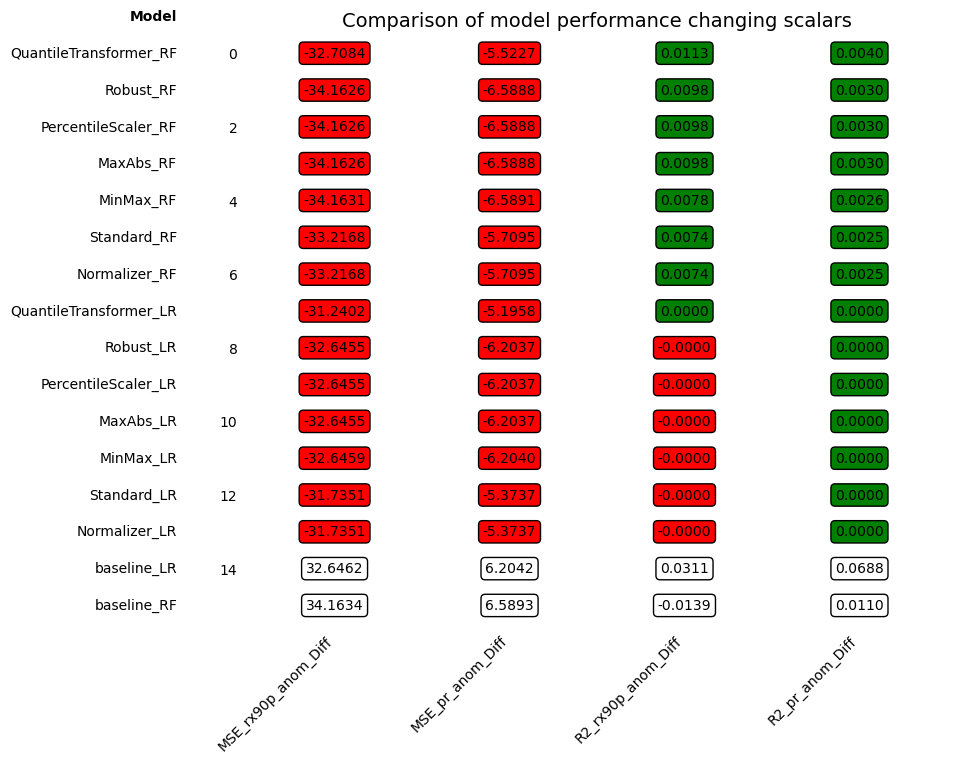

In [43]:
# Add a new column
plot_experiments_difference(df_sorted, title = "Comparison of model performance changing scalars", out_path="/home/vgarcia/experiments/plots/Scalars.png", baseline_df=baseline_df)

# Coords aggregation

In [ ]:
df_sorted, baseline_df = load_experiment_results("/home/vgarcia/experiments//home/vgarcia/experiments/Coords_aggregation", baseline_name="baseline", models=["LR", "RF"])
baseline_df = pd.DataFrame.from_dict(baseline_df, orient='index')
baseline_df.columns = [col + '_Diff' if col != 'Model' else col for col in baseline_df.columns]
df_sorted = df_sorted[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]
baseline_df = baseline_df[["Model", "MSE_rx90p_anom_Diff", "MSE_pr_anom_Diff", "R2_rx90p_anom_Diff", "R2_pr_anom_Diff"]]
full_df = pd.concat([df_sorted, baseline_df], ignore_index=True)
full_df.to_latex()

ValueError: No objects to concatenate